# GridSearchCV 적용 (Covid19 확진자 데이터)

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
import warnings
warnings.filterwarnings(action="ignore")

from helper.util import *
from helper.plot import *
from helper.timeserise import *

import seaborn as sb
from matplotlib import pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from pandas import to_datetime, DatetimeIndex, Series, date_range, concat

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

import concurrent.futures as futures

Importing plotly failed. Interactive plots will not work.


### [2] 데이터 가져오기

In [2]:
origin = my_read_excel("https://data.hossam.kr/tsdata/covid19_seoul_230531.xlsx", save = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212 entries, 0 to 1211
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   서울시 기준일            1212 non-null   object 
 1   서울시 확진자            1212 non-null   int64  
 2   서울시 추가 확진          1211 non-null   float64
 3   서울시 치료중            1212 non-null   int64  
 4   서울시 퇴원             770 non-null    float64
 5   서울시 추가 퇴원          770 non-null    float64
 6   서울시 사망             1212 non-null   int64  
 7   서울시 의심환자 전체        187 non-null    float64
 8   서울시 의심환자 검사중       188 non-null    float64
 9   서울시 의심환자 검사결과(음성)  188 non-null    float64
 10  전국 기준일             1212 non-null   object 
 11  전국 확진              1212 non-null   float64
 12  전국 추가 확진           1211 non-null   float64
 13  전국 치료중             1212 non-null   int64  
 14  전국 퇴원              770 non-null    float64
 15  전국 사망              1212 non-null   int64  
 16  전국 의심환자 전체         187 n

## #02. 데이터 전처리

### [1] 필요한 데이터만 추출

In [3]:
df = origin[['서울시 기준일', '서울시 추가 확진']]
my_pretty_table(df.head())

+----+-----------------+--------------------+
|    | 서울시 기준일   |   서울시 추가 확진 |
|----+-----------------+--------------------|
|  0 | 2023-05-31      |               5987 |
|  1 | 2023-05-30      |               3326 |
|  2 | 2023-05-29      |               1393 |
|  3 | 2023-05-28      |               1393 |
|  4 | 2023-05-27      |               4078 |
+----+-----------------+--------------------+


### [2] 결측치 처리

#### (1) 결측치 존재 확인

In [4]:
df.isna().sum()

서울시 기준일      0
서울시 추가 확진    1
dtype: int64

#### (2) 결측치 제거

In [5]:
df2 = df.fillna(0)
df2.isna().sum()

서울시 기준일      0
서울시 추가 확진    0
dtype: int64

### [3] 날짜 타입에 대한 형변환

```python
to_datetime(날짜필드, 형식문자열)
```

In [6]:
df2['서울시 기준일'] = to_datetime(df2['서울시 기준일'].str.strip(), format="%Y-%m-%d")
df2.dtypes

서울시 기준일      datetime64[ns]
서울시 추가 확진           float64
dtype: object

### [3] 컬럼이름 변경

In [7]:
df3 = df2.rename(columns={"서울시 기준일": "ds", "서울시 추가 확진": "y"})
my_pretty_table(df3.head())

+----+---------------------+------+
|    | ds                  |    y |
|----+---------------------+------|
|  0 | 2023-05-31 00:00:00 | 5987 |
|  1 | 2023-05-30 00:00:00 | 3326 |
|  2 | 2023-05-29 00:00:00 | 1393 |
|  3 | 2023-05-28 00:00:00 | 1393 |
|  4 | 2023-05-27 00:00:00 | 4078 |
+----+---------------------+------+


## #03. 탐색적 데이터 분석

### [1] 날짜 컬럼을 인덱스로 설정

In [8]:
df4 = df3.set_index("ds")
df4.head()

,y
ds,
2023-05-31,5987.0
2023-05-30,3326.0
2023-05-29,1393.0
2023-05-28,1393.0
2023-05-27,4078.0


### [2] ACF, PACF 플롯

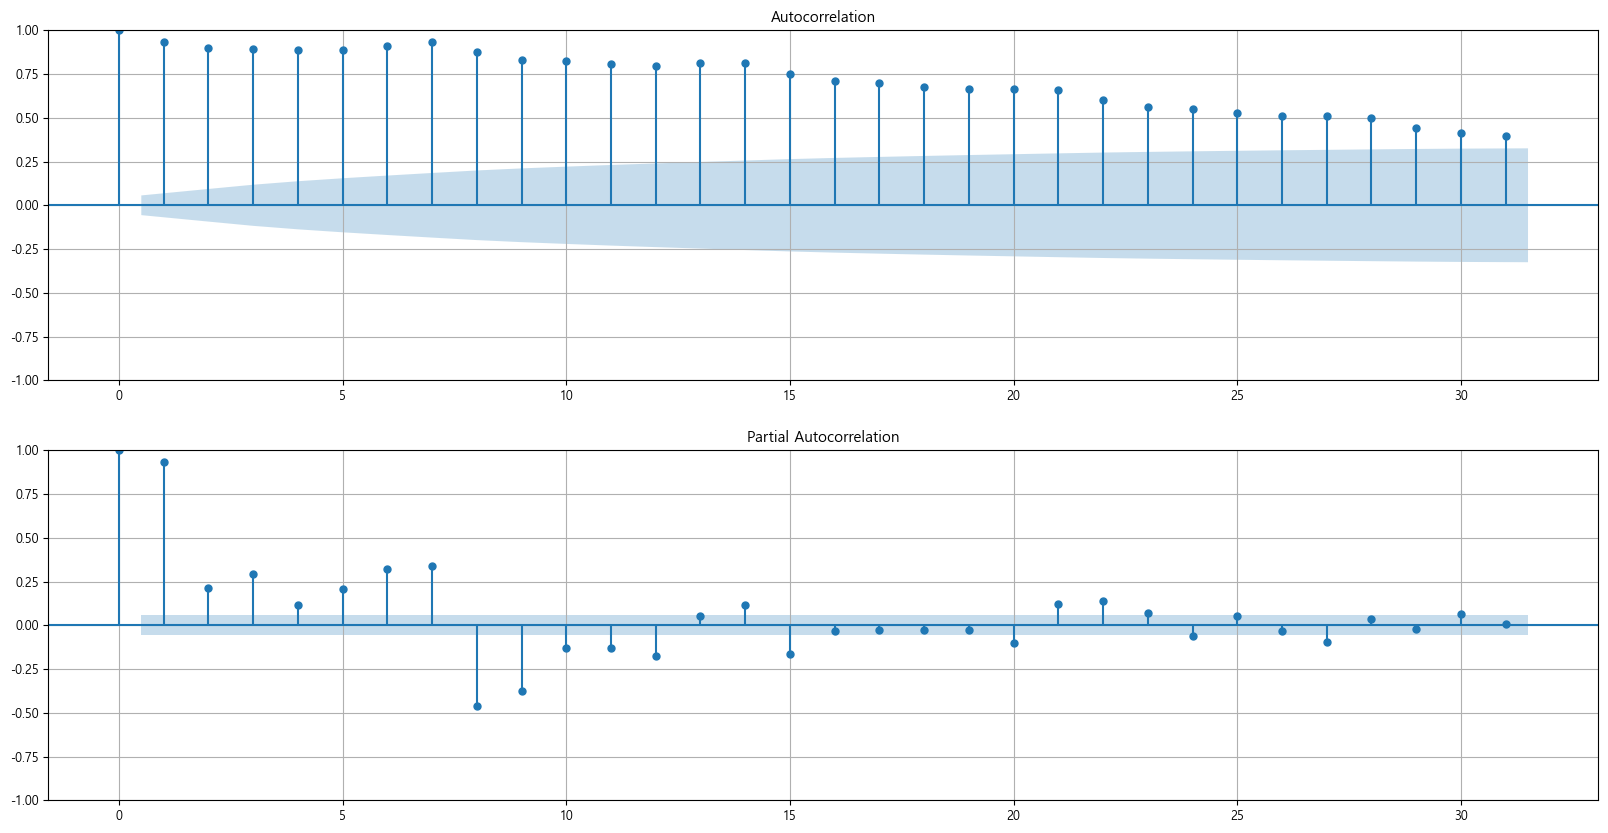

In [9]:
my_acf_pacf_plot(df4['y'], figsize=(20, 5))

### [3] 성분 분해

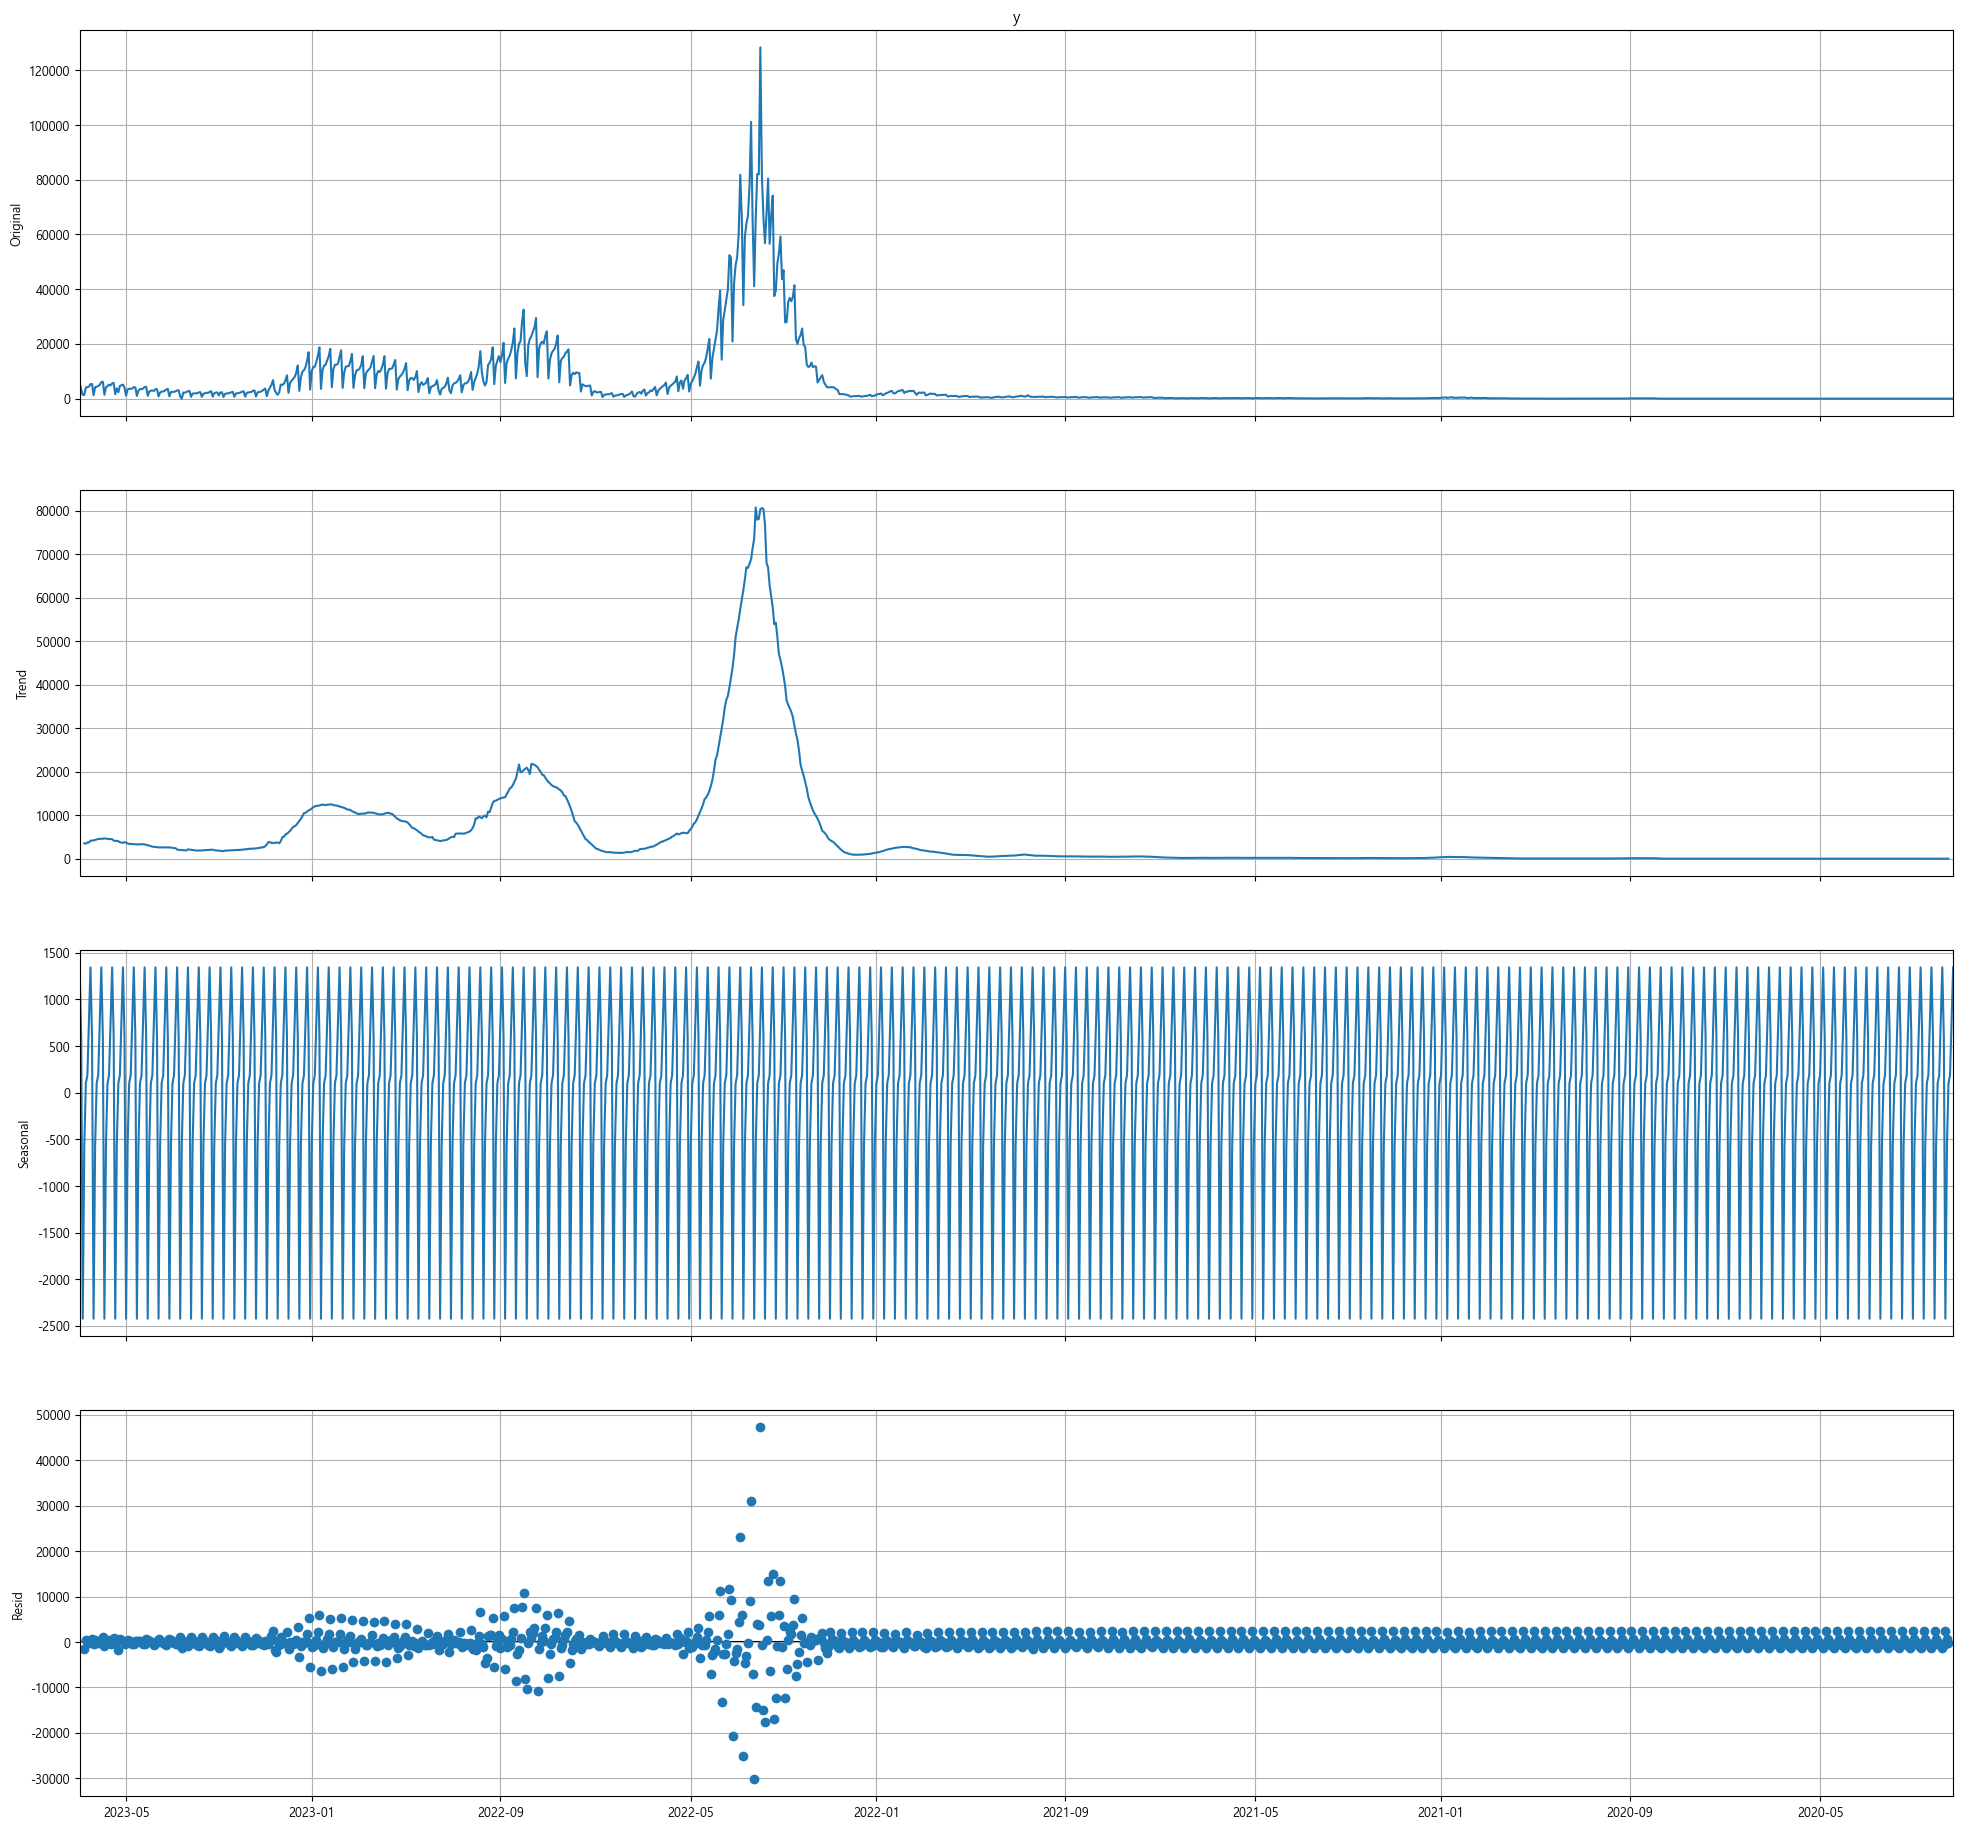

,original,trend,seasonal,resid
ds,,,,
2023-05-31,5987.0,NaN,1343.186784,NaN
2023-05-30,3326.0,NaN,595.143595,NaN
2023-05-29,1393.0,NaN,-2422.726006,NaN
2023-05-28,1393.0,3547.000000,-566.656973,-1587.343027
2023-05-27,4078.0,3450.571429,100.836008,526.592564
...,...,...,...,...
2020-02-09,0.0,0.000000,-566.656973,566.656973
2020-02-08,0.0,0.000000,100.836008,-100.836008
2020-02-07,0.0,NaN,186.890273,NaN


In [10]:
my_seasonal_decompose(df4['y'], figsize=(20, 5))

## #04. Prophet 분석 모델 구현

### [1] 튜닝하고자 하는 하이퍼 파라미터 정의

In [11]:
params = ParameterGrid({
    #'growth': ['linear', 'logistic'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality': [True, False],
    'daily_seasonality':  [True, False],
    'yearly_seasonality': [True, False],
})

print('Total Possible Models', len(params))

Total Possible Models 144


### [2] 훈련, 검증 데이터 분리

In [12]:
train, test = my_timeseries_split(df3)
train.shape, test.shape

((969, 2), (243, 2))

### [3] GridSearchCV 구성

#### (1) 단순 반복 처리

In [ ]:
%%time

for p in params:
    m = Prophet(**p)
    m.fit(train)

    future = m.make_future_dataframe(periods=len(test), freq='D')
    forecast = m.predict(future)
    #my_pretty_table(forecast)

    pred = forecast[['ds', 'yhat']][-len(test):]
    #print(pred)
    #print(test)
    score = np.sqrt(mean_squared_error(test['y'].values, pred['yhat'].values))
    print('RMSE ------------------------------------',score)

#### (2) 비동기 처리 구현

##### 비동기 작업을 수행할 단위기능 함수를 정의

In [ ]:
def covid19_prophet(train,test, **p):
    m = Prophet(**p)
    m.fit(train)

    future = m.make_future_dataframe(periods=len(test), freq='D')
    forecast = m.predict(future)

    pred = forecast[['ds', 'yhat']][-len(test):]
    score = np.sqrt(mean_squared_error(test['y'].values, pred['yhat'].values))
    
    return m, score, dict(p)

In [ ]:
%%time

result = []
processes = []

with futures.ThreadPoolExecutor() as executor:
    for p in params:
        processes.append(executor.submit(covid19_prophet, train,test, **p))

    for p in futures.as_completed(processes):
        m, score, p = p.result()
        result.append({
            "model": m,
            "params": p,
            "score": score
        })

result_df = DataFrame(result).sort_values("score").reset_index(drop=True)
my_pretty_table(result_df)

#### (3) 최적 모델을 통한 예측치 확인

In [ ]:
best_model = result_df.iloc[0]['model']
best_model.make_future_dataframe(periods=len(test)+7, freq='D')
forecast = best_model.predict(future)

fig = best_model.plot(forecast, figsize=(15, 5))
fig.set_dpi(200)
ax = fig.gca()
plt.show()
plt.close()